# RRR Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("../../")

import pyaldata as pyal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from tools.reports.report_initial import run_initial_report
from tools.params import Params, colors
from tools.dsp.preprocessing import preprocess
import tools.viz.mean_firing as firing
import tools.viz.dimensionality as dim
import tools.viz.rrr as viz_rrr
import tools.viz.utilityTools as vizutils
import tools.decoding.rrr as rrr

import tools.decoding.decodeTools as decutils
import tools.dataTools as dt

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import cupy as cp





# Initial analysis

In [2]:
data_dir = "/data/bnd-data/raw/"
session = 'M062_2025_03_20_14_00'

df = pyal.load_pyaldata(data_dir + session[:4] + '/' + session)
df = preprocess(df, only_trials=False)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
field values_Sol_direction could not be converted to int.
field idx_Sol_direction could not be converted to int.
field values_Sol_duration could not be converted to int.
field idx_Sol_duration could not be converted to int.
field idx_sol_on could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field all_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to i

/home/me24/.cache/pypoetry/virtualenvs/earthquake-analysis-Z8riI-lB-py3.12/src/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_X might be a time-varying field. It matches the length of VAL_spikes on 99.85955056179775% of trials
  warnings.warn(
/home/me24/.cache/pypoetry/virtualenvs/earthquake-analysis-Z8riI-lB-py3.12/src/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_X might be a time-varying field. It matches the length of VAL_spikes on 99.85955056179775% of trials
  warnings.warn(
/home/me24/.cache/pypoetry/virtualenvs/earthquake-analysis-Z8riI-lB-py3.12/src/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_Y might be a time-varying field. It matches the length of VAL_spikes on 99.85955056179775% of trials
  warnings.warn(
/home/me24/.cache/pypoetry/virtualenvs/earthquake-analysis-Z8riI-lB-py3.12/src/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_Y might be a time-varying field. It matches the length of VAL_spikes on 99.85955056179775% of tr

Combined every 3 bins
Resulting VAL_spikes ephys data shape is (NxT): (155, 16000)
Resulting SSp_spikes ephys data shape is (NxT): (118, 16000)
Resulting all_spikes ephys data shape is (NxT): (34, 16000)
Resulting MOp_spikes ephys data shape is (NxT): (163, 16000)
Resulting CP_spikes ephys data shape is (NxT): (356, 16000)


In [3]:
def plot_rrr_heatmap_from_dict_per_area(dict_, areas, figsize=(8, 6), ax=None, title=None):

    arr = []
    for area_x in areas:
        arr_ = []
        for area_y in areas:
            arr_.append(dict_[area_x][area_y])
        arr.append(arr_)
    arr = np.array(arr)
    
    # Plot the heatmap of means
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(arr, cmap="GnBu", annot=True, fmt='.4f', xticklabels=areas, 
                yticklabels=areas, square=False, vmin=0, vmax=1, ax=ax)
    ax.set_xlabel('Response areas')
    ax.set_ylabel('Predictor areas')
    if title is None:
        ax.set_title("Reduced Rank Regression R2")
    else:
        ax.set_title(title)
    plt.show()

## Trial

In [4]:
def get_data(df, area, n_components=20, condition='trial', epoch=None):
    df_rrr = pyal.select_trials(df, df.trial_name==condition)

    if epoch is not None:
        df_rrr = pyal.restrict_to_interval(df_rrr, epoch_fun=epoch)

    # Get data
    rates = np.concatenate(df_rrr[f"{area}_rates"].values, axis=0)
    model = PCA(n_components=n_components, svd_solver="full")
    model.fit(rates)
    X = model.fit_transform(rates)
    
    return X   

In [ ]:



areas=["MOp", "SSp", "CP", "VAL"]
results_rrr_trial = {}
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
n_comp=20

for area_x in areas:
    results_rrr_trial[area_x] = {}
    # X, n_time = get_data(df, area_x)
    X = get_data(df, area_x, epoch=Params.perturb_epoch)

    for area_y in areas:
        Y = get_data(df, area_y, epoch=Params.perturb_epoch)

        # Get data
        r2 = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            # Fit model
            model = rrr.ReducedRankRegression(r=10, lam=0.05, use_sklearn=False)
            model.fit(X=X_train, Y=Y_train)
            
            # Predict
            Y_pred_test = model.predict(X_test)
            multi_r2, col_r2 = decutils.multivariate_r2(Y_test, Y_pred_test)
            # print(f"{area_x} to {area_y}: {multi_r2:.3f}")
            r2.append(multi_r2)

        print(f"{area_x} to {area_y}: {np.array(r2).mean():.3f}")

        results_rrr_trial[area_x][area_y] = np.array(r2).mean()


mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

# You can clear the memory pool by calling `free_all_blocks`.
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()
print('Freed memory pool')

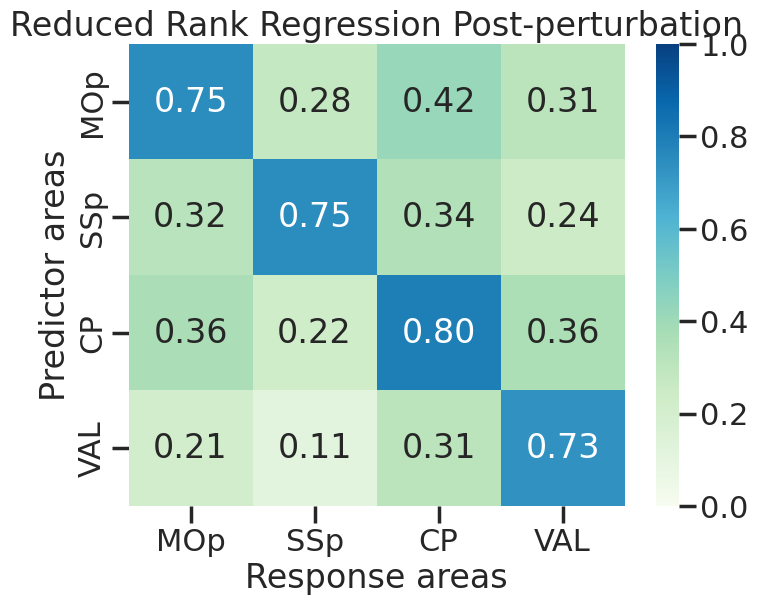

In [81]:
import tools.viz.rrr as viz_rrr
from pathlib import Path

fig = viz_rrr.plot_rrr_heatmap_from_dict_per_area(
    results_rrr_trial, 
    areas,  
    title='Reduced Rank Regression Post-perturbation'
)
figpath = Path('/home/me24/tmp_results')

fig.savefig(figpath / 'rrr_post_perturb.pdf', bbox_inches='tight')

In [5]:
results_rrr_inter = {}
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
n_comp=20
areas = ['MOp', 'SSp', 'CP', 'VAL']

for area_x in areas:
    results_rrr_inter[area_x] = {}
    # X, n_time = get_data(df, area_x)
    X = get_data(df, area_x, condition='intertrial')

    for area_y in areas:
        Y = get_data(df, area_y, condition='intertrial')

        # Get data
        r2 = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            # Fit model
            model = rrr.ReducedRankRegression(r=10, lam=0.05, use_sklearn=False)
            model.fit(X=X_train, Y=Y_train)
            
            # Predict
            Y_pred_test = model.predict(X_test)
            multi_r2, col_r2 = decutils.multivariate_r2(Y_test, Y_pred_test)
            # print(f"{area_x} to {area_y}: {multi_r2:.3f}")
            r2.append(multi_r2)

        print(f"{area_x} to {area_y}: {np.array(r2).mean():.3f}")

        results_rrr_inter[area_x][area_y] = np.array(r2).mean()


mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

# You can clear the memory pool by calling `free_all_blocks`.
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()
print('Freed memory pool')

MOp to MOp: 0.720
MOp to SSp: 0.226
MOp to CP: 0.352
MOp to VAL: 0.330
SSp to MOp: 0.261
SSp to SSp: 0.717
SSp to CP: 0.290
SSp to VAL: 0.267
CP to MOp: 0.305
CP to SSp: 0.210
CP to CP: 0.781
CP to VAL: 0.368
VAL to MOp: 0.200
VAL to SSp: 0.114
VAL to CP: 0.292
VAL to VAL: 0.737
Freed memory pool


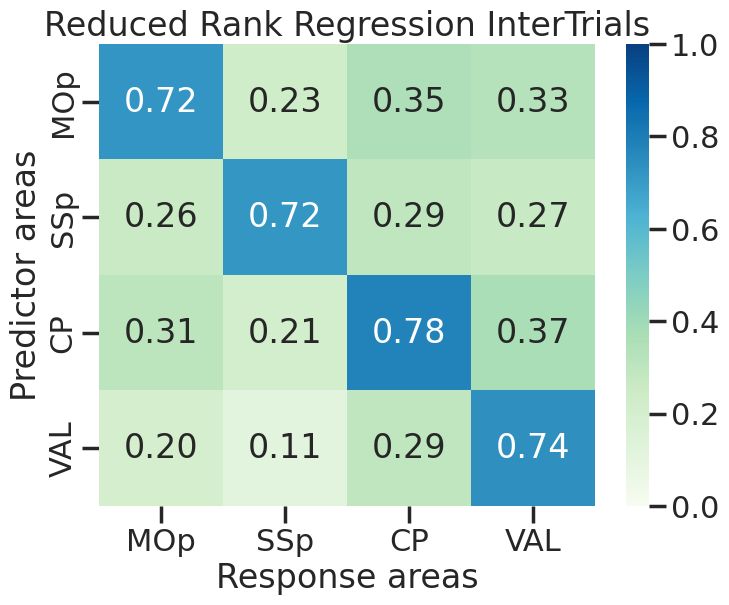

In [7]:
import tools.viz.rrr as viz_rrr
from pathlib import Path

fig = viz_rrr.plot_rrr_heatmap_from_dict_per_area(
    results_rrr_inter, 
    areas,  
    title='Reduced Rank Regression InterTrials'
)
# figpath = Path('/home/me24/tmp_results')

# fig.savefig(figpath / 'rrr_inter.pdf', bbox_inches='tight')

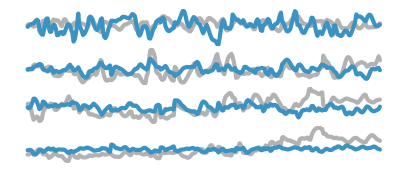

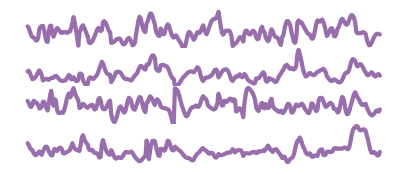

In [16]:
Y_pred_train = model.predict(X_train)

idx1 = 700
idx2 = 1000 
pcs = 4

# Plot
with plt.style.context('seaborn-v0_8-bright'):
    sns.set_theme(context='poster', style='ticks')
    fig, axes = plt.subplots(pcs, 1, figsize=(5, 2), gridspec_kw={'hspace': 0.05})
    for pc, ax in zip(range(pcs), axes):

        ax.plot(Y_train[idx1:idx2, pc], color='gray', alpha=0.6)
        ax.plot(Y_pred_train[idx1:idx2, pc], color=getattr(colors, "CP_light"))
        
        ax.set_yticks([])
        ax.set_xticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

figpath = Path('/home/me24/tmp_results')

fig.savefig(figpath / 'rrr_demo1.pdf', bbox_inches='tight')
plt.show()

with plt.style.context('seaborn-v0_8-bright'):
    sns.set_theme(context='poster', style='ticks')
    fig, axes = plt.subplots(pcs, 1, figsize=(5, 2), gridspec_kw={'hspace': -0.05})
    for pc, ax in zip(range(pcs), axes):

        ax.plot(X_train[idx1:idx2, pc], color=getattr(colors, "MOp_light"))
        # ax.plot(X_train[idx1:idx2, pc], color='gray', alpha=0.5)
        ax.set_yticks([])
        ax.set_xticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
fig.savefig(figpath / 'rrr_demo2.pdf', bbox_inches='tight')

plt.show()

## Use 3 sessions for free data

In [ ]:
# Concatenate DF

areas=["MOp", "SSp", "CP", "VAL"]

sessions = [
    # 'M046_2024_12_18_16_00' 
    # 'M046_2024_12_19_13_30',
    # 'M061_2025_03_05_14_00',
    # 'M061_2025_03_06_14_00',
    'M062_2025_03_19_14_00',
    'M062_2025_03_20_14_00',
    'M062_2025_03_21_14_00',
    # 'M063_2025_03_12_14_00',
    # 'M063_2025_03_13_14_00',
    # 'M063_2025_03_14_15_30'
]

data_dir = "/data/bnd-data/raw/"

df_ = []
for session in sessions:
    df = pyal.load_pyaldata(data_dir + session[:4] + '/' + session)
    df = preprocess(df, only_trials=False)

    df_rrr = pyal.select_trials(df, df.trial_name=='free')
    df_.append(df_rrr)

df = pd.concat(df_, ignore_index=True)
del df_

In [4]:
df.head()

,animal,session,trial_id,trial_name,trial_length,bin_size,idx_trial_start,idx_trial_end,idx_CPI,values_before_camera_trigger,...,right_knee,right_knee_angle,right_paw,right_shoulder,right_wrist,right_wrist_angle,shoulder_center,tail_base,tail_middle,tail_tip
0,M062,M062_2025_03_19_14_00,0,free,48000,0.03,0,15999,[],1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M062,M062_2025_03_19_14_00,721,free,48000,0.03,122000,137999,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M062,M062_2025_03_20_14_00,0,free,48000,0.03,0,15999,[],1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M062,M062_2025_03_20_14_00,711,free,48000,0.03,122000,137999,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M062,M062_2025_03_21_14_00,0,free,48000,0.03,0,15999,[],1.0,...,"[[-5.55702965362151, 9.25302694547318, 208.576...","[91.83688901242552, 66.88844610762345, 60.8666...","[[-21.544624993077928, 15.59213585342566, 173....","[[-20.696447034548893, 6.3530477889164985, 184...","[[-20.74175353077833, 14.09288557640054, 178.2...","[169.940851205487, 154.6560699976227, 119.5901...","[[-16.183278228502267, -3.301151668129256, 179...","[[4.205131246442705, 4.405653047291428, 217.13...","[[-9.300295877613552, 12.401804723293244, 246....","[[-41.001408827944196, -1.5144924376660054, 27..."


In [8]:
results_rrr_free = {}
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
n_comp=20

for area_x in areas:
    results_rrr_free[area_x] = {}
    # X, n_time = get_data(df, area_x)
    X = get_data(df, area_x, condition='free')

    for area_y in areas:
        Y = get_data(df, area_y, condition='free')

        # Get data
        r2 = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            # Fit model
            model = rrr.ReducedRankRegression(r=10, lam=0.05, use_sklearn=False)
            model.fit(X=X_train, Y=Y_train)
            
            # Predict
            Y_pred_test = model.predict(X_test)
            multi_r2, col_r2 = decutils.multivariate_r2(Y_test, Y_pred_test)
            # print(f"{area_x} to {area_y}: {multi_r2:.3f}")
            r2.append(multi_r2)

        print(f"{area_x} to {area_y}: {np.array(r2).mean():.3f}")

        results_rrr_free[area_x][area_y] = np.array(r2).mean()


mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

# You can clear the memory pool by calling `free_all_blocks`.
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()
print('Freed memory pool')

MOp to MOp: 0.793
MOp to SSp: 0.285
MOp to CP: 0.510
MOp to VAL: 0.593
SSp to MOp: 0.406
SSp to SSp: 0.736
SSp to CP: 0.428
SSp to VAL: 0.511
CP to MOp: 0.463
CP to SSp: 0.255
CP to CP: 0.829
CP to VAL: 0.606
VAL to MOp: 0.391
VAL to SSp: 0.165
VAL to CP: 0.469
VAL to VAL: 0.838
Freed memory pool


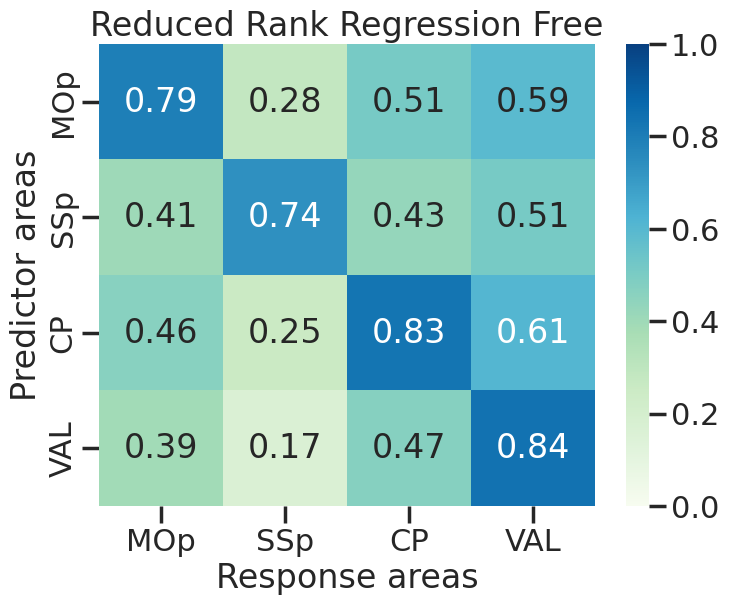

In [9]:
import tools.viz.rrr as viz_rrr
from pathlib import Path

fig = viz_rrr.plot_rrr_heatmap_from_dict_per_area(
    results_rrr_free, 
    areas,  
    title='Reduced Rank Regression Free'
)
# figpath = Path('/home/me24/tmp_results')

# fig.savefig(figpath / 'rrr_free.pdf', bbox_inches='tight')

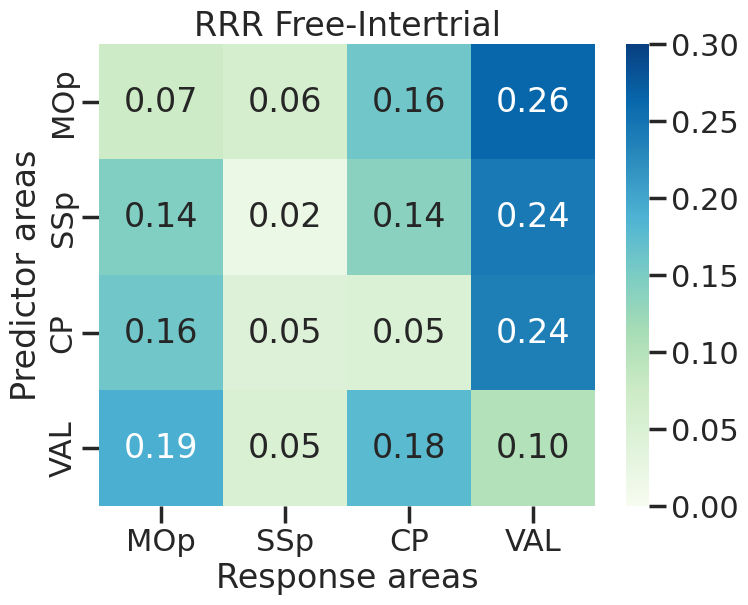

In [15]:
# Assuming results_rrr_free1 and results_rrr_free2 have the same keys
results_rrr_difference = {}

for area_x in results_rrr_inter:
    results_rrr_difference[area_x] = {}
    for area_y in results_rrr_free[area_x]:
        val1 = results_rrr_inter[area_x][area_y]
        val2 = results_rrr_free[area_x][area_y]
        results_rrr_difference[area_x][area_y] = val2 - val1


fig = viz_rrr.plot_rrr_heatmap_from_dict_per_area(
    results_rrr_difference, 
    areas,  
    title='RRR Free-Intertrial',
    vmax=0.3
    
)

figpath = Path('/home/me24/tmp_results')

fig.savefig(figpath / 'rrr_difference.pdf', bbox_inches='tight')

## Increasing Rs

In [51]:
rrr_free_different_r = {}
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
n_comp=20

r = np.arange(2, 21)

for area_x in areas:
    rrr_free_different_r[area_x] = {}
    # X, n_time = get_data(df, area_x)
    X = get_data(df, area_x, condition='free')

    for area_y in areas:
        Y = get_data(df, area_y, condition='free')

        # Get data
        ranks = []
        for r_ in r:
            r2 = []

            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                Y_train, Y_test = Y[train_index], Y[test_index]

                # Fit model
                model = rrr.ReducedRankRegression(r=r_, lam=0.05, use_sklearn=False)
                model.fit(X=X_train, Y=Y_train)
                
                # Predict
                Y_pred_test = model.predict(X_test)
                multi_r2, col_r2 = decutils.multivariate_r2(Y_test, Y_pred_test)
                r2.append(multi_r2)

            ranks.append(np.array(r2).mean())
            
        rrr_free_different_r[area_x][area_y] = np.array(ranks)

        print(f"{area_x} to {area_y}. Rank {r_}: {np.array(r2).mean():.3f}")


mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

# You can clear the memory pool by calling `free_all_blocks`.
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()
print('Freed memory pool')

MOp to MOp. Rank 20: 1.000
MOp to SSp. Rank 20: 0.288
MOp to CP. Rank 20: 0.513
MOp to VAL. Rank 20: 0.594
SSp to MOp. Rank 20: 0.408
SSp to SSp. Rank 20: 1.000
SSp to CP. Rank 20: 0.431
SSp to VAL. Rank 20: 0.512
CP to MOp. Rank 20: 0.467
CP to SSp. Rank 20: 0.258
CP to CP. Rank 20: 1.000
CP to VAL. Rank 20: 0.608
VAL to MOp. Rank 20: 0.393
VAL to SSp. Rank 20: 0.167
VAL to CP. Rank 20: 0.471
VAL to VAL. Rank 20: 1.000
Freed memory pool


In [32]:
rrr_free_different_r[area_x][area_y].values()


dict_values([0.475368975404365, 0.536772586589912, 0.5923566981809486, 0.6373975640822399, 0.6733826600421446, 0.7066135162027084, 0.738540417605519, 0.7668545468703736, 0.7934557907232359, 0.8177496730585545, 0.8402241061202798, 0.8622729530368256, 0.8839521025306084, 0.9046350978496497, 0.9252523161108929, 0.944603689216535, 0.9635769832800551, 0.9818903700458014, 0.9999999999999698])

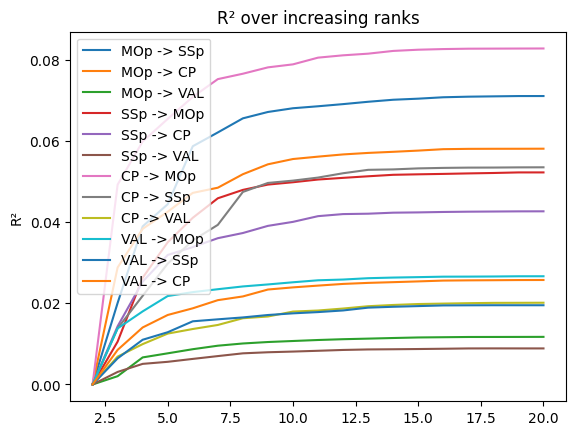

In [52]:
import matplotlib.pyplot as plt

# Loop over each source-target region pair
r = np.arange(2, 21)

fig, ax = plt.subplots()
for area_x in rrr_free_different_r.keys():
    for area_y in rrr_free_different_r[area_x].keys():
        if area_x == area_y:
            continue
        min_max = (rrr_free_different_r[area_x][area_y] - rrr_free_different_r[area_x][area_y][0]) / (rrr_free_different_r[area_x][area_y][-1] - rrr_free_different_r[area_x][area_y][0])
        ax.plot(r, rrr_free_different_r[area_x][area_y] - rrr_free_different_r[area_x][area_y][0], label=f'{area_x} -> {area_y}')
        
ax.set_title(f'R² over increasing ranks')
ax.set_ylabel('R²')
ax.legend()

plt.show()


In [1]:
rrr_inter_different_r = {}
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
n_comp=20

r = np.arange(2, 21)

for area_x in areas:
    rrr_inter_different_r[area_x] = {}
    # X, n_time = get_data(df, area_x)
    X = get_data(df, area_x, condition='intertrial')

    for area_y in areas:
        Y = get_data(df, area_y, condition='intertrial')

        # Get data
        ranks = []
        for r_ in r:
            r2 = []

            for train_index, test_index in kf.split(X):
                assert test_index != train_index
                X_train, X_test = X[train_index], X[test_index]
                Y_train, Y_test = Y[train_index], Y[test_index]

                # Fit model
                model = rrr.ReducedRankRegression(r=r_, lam=0.05, use_sklearn=False)
                model.fit(X=X_train, Y=Y_train)
                
                # Predict
                Y_pred_test = model.predict(X_test)
                multi_r2, col_r2 = decutils.multivariate_r2(Y_test, Y_pred_test)
                r2.append(multi_r2)

            ranks.append(np.array(r2).mean())
            
        rrr_inter_different_r[area_x][area_y] = np.array(ranks)

        print(f"{area_x} to {area_y}. Rank {r_}: {np.array(r2).mean():.3f}")


mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

# You can clear the memory pool by calling `free_all_blocks`.
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()
print('Freed memory pool')

NameError: name 'KFold' is not defined

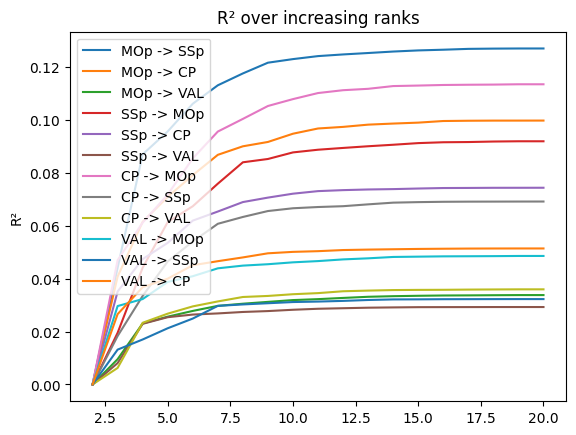

In [53]:
import matplotlib.pyplot as plt

# Loop over each source-target region pair
r = np.arange(2, 21)

fig, ax = plt.subplots()
for area_x in rrr_inter_different_r.keys():
    for area_y in rrr_inter_different_r[area_x].keys():
        if area_x == area_y:
            continue
        min_max = (rrr_inter_different_r[area_x][area_y] ) / (rrr_inter_different_r[area_x][area_y][-1] - rrr_free_different_r[area_x][area_y][0])
        ax.plot(r, rrr_inter_different_r[area_x][area_y] - rrr_inter_different_r[area_x][area_y][0], label=f'{area_x} -> {area_y}')
        
ax.set_title(f'R² over increasing ranks')
ax.set_ylabel('R²')
ax.legend()

plt.show()


## Confirming with correlations

In [96]:
def get_unique_pariwise_corr(arr):
    """Return unique pairwise correlations between neurons

    Args:
        arr (np.ndarray): T x N array
    """
    correlation_matrix = np.corrcoef(arr.T)
    triu_indices = np.triu_indices(correlation_matrix.shape[0], k=1)

    return correlation_matrix[triu_indices]

def get_correlations_between_areas(arr_area1, arr_area2):
    if arr_area1.shape[0] != arr_area2.shape[0]:
        raise ValueError("The number of time points (T) must be the same for both areas.")
    
    correlation_matrix = np.corrcoef(arr_area1.T, arr_area2.T)[:arr_area1.shape[1], arr_area1.shape[1]:]
    return correlation_matrix.flatten()

def get_correlations_within_vs_correlations_across(df, areas):
    area_corr = {}
    for area_i in areas:
        area_corr[area_i] = {}
        for area_j in areas:
            if area_j != area_i:
                area_corr[area_i][area_j] = get_correlations_between_areas(
                    np.concatenate(df[f"{area_i}_rates"].values, axis=0),
                    np.concatenate(df[f"{area_j}_rates"].values, axis=0)
                    )
            else:
                area_corr[area_i][area_j] = get_unique_pariwise_corr(np.concatenate(df[f"{area_i}_rates"].values, axis=0))

    return area_corr

def plot_heatmap_corr_per_area(df, areas, figsize=(8, 6), ax=None):

    area_corr_dict = get_correlations_within_vs_correlations_across(df, areas)

    mean_corrs = []  # List to store the mean correlations for each area
    for key, value in area_corr_dict.items():
        mean_area_corr = []
        for key_, value_ in value.items():
            mean_area_corr.append(np.mean(value_))

        mean_corrs.append(mean_area_corr)
    
    mean_corrs_array = np.array(mean_corrs)
    
    # Plot the heatmap of means
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(mean_corrs_array, cmap="coolwarm", annot=True, fmt='.4f', xticklabels=areas, yticklabels=areas, square=False, vmin=-0.032, vmax=0.032, ax=ax)
    ax.set_title("Mean Pairwise Correlations Between Brain Areas")
    plt.show()


def plot_correlations_within_vs_correlations_across(df, areas, ax=None, figsize=(5, 5), plot=True):

    area_corr_dict = get_correlations_within_vs_correlations_across(df, areas)

    mean_corrs_across = []  # List to store the mean correlations for each area
    mean_cross_within = []
    for key, value in area_corr_dict.items():
        mean_area_corr = []
        for key_, value_ in value.items():
            if key_ != key:  # avoid adding the own correlations
                mean_area_corr.append(value_)
            else:
                mean_cross_within.append(np.mean(value_))

        mean_area_corr = np.concatenate(mean_area_corr)
        mean_corrs_across.append(np.mean(mean_area_corr))

    if plot:

        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        ax.scatter(mean_cross_within, mean_corrs_across, c=[getattr(colors, area) for area in areas], s=50)
        ax.plot(np.arange(-1, 1, 0.001), np.arange(-1, 1, 0.001), 'k--')
        ax.set_xlim([-0.1, 0.1])
        ax.set_ylim([-0.1, 0.1])
        ax.set_ylabel('Pairwise corr. across')
        ax.set_xlabel('Pairwise corr. within')
        ax.set_title('Pairwise correlation across vs. within')


    return np.array(mean_corrs_across), np.array(mean_cross_within)

In [ ]:
areas=["MOp", "SSp", "CP", "VAL"]

plot_correlations_within_vs_correlations_across(df, areas, figsize=(7, 4))

In [97]:
areas=["MOp", "SSp", "CP", "VAL"]

mean_corr_across_inter, mean_corr_within_inter = plot_correlations_within_vs_correlations_across(pyal.select_trials(df, df.trial_name == 'intertrial'), areas, figsize=(7, 4), plot=False)

In [98]:
areas=["MOp", "SSp", "CP", "VAL"]

mean_corr_across_free, mean_corr_within_free = plot_correlations_within_vs_correlations_across(pyal.select_trials(df, df.trial_name == 'free'), areas, figsize=(7, 4), plot=False)

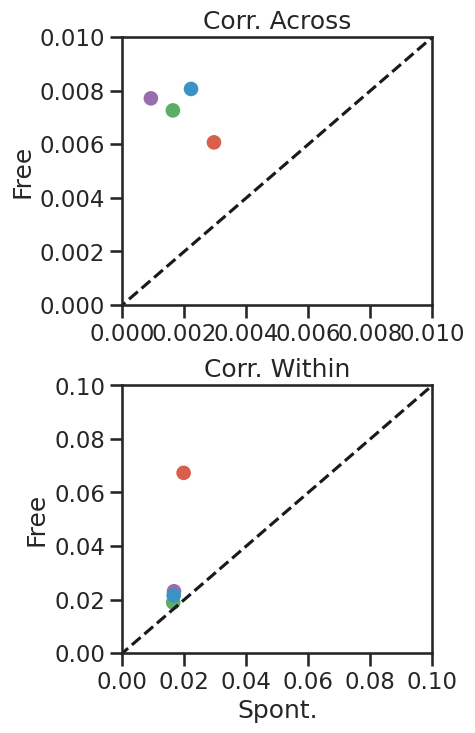

In [99]:
with plt.style.context('seaborn-v0_8-bright'):
    sns.set_theme(context='talk', style='ticks')
    fig, ax = plt.subplots(2, 1, figsize=(4, 8), gridspec_kw={'hspace': 0.3})

    ax[0].scatter(x=np.abs(mean_corr_across_inter), y=np.abs(mean_corr_across_free), c=[getattr(colors, f"{area}_light") for area in areas])
    ax[0].plot(np.arange(-1, 1, 0.001), np.arange(-1, 1, 0.001), 'k--')

    ax[0].set_xlim([0, 0.01])
    ax[0].set_ylim([0, 0.01])
    ax[1].set_xlabel('Spont.')
    ax[0].set_ylabel('Free')
    ax[1].set_ylabel('Free')

    ax[0].set_title('Corr. Across')

    ax[1].scatter(x=np.abs(mean_corr_within_inter), y=np.abs(mean_corr_within_free), c=[getattr(colors, f"{area}_light") for area in areas])
    ax[1].plot(np.arange(-1, 1, 0.001), np.arange(-1, 1, 0.001), 'k--')

    ax[1].set_xlim([0, 0.1])
    ax[1].set_ylim([0, 0.1])
    ax[1].set_title('Corr. Within')

plt.show()

## Test multiple sessions

In [ ]:
corr_within = {}
corr_across = {}
# areas=["MOp", "SSp", "CP", "VAL"]

sessions = [
    'M046_2024_12_18_16_00',
    'M046_2024_12_19_13_30',
    'M061_2025_03_05_14_00',
    'M061_2025_03_06_14_00',
    'M062_2025_03_19_14_00',
    'M062_2025_03_20_14_00',
    'M062_2025_03_21_14_00',
    'M063_2025_03_12_14_00',
    'M063_2025_03_13_14_00',
    'M063_2025_03_14_15_30'
]

data_dir = "/data/bnd-data/raw/"


for session in sessions:
    corr_across[session] = {}
    corr_within[session] = {}
    df = pyal.load_pyaldata(data_dir + session[:4] + '/' + session)
    df = preprocess(df, only_trials=False)
    corr_across[session]['free'], corr_within[session]['free'] = plot_correlations_within_vs_correlations_across(pyal.select_trials(df, df.trial_name == 'free'), areas, plot=False)
    corr_across[session]['intertrial'], corr_within[session]['intertrial'] = plot_correlations_within_vs_correlations_across(pyal.select_trials(df, df.trial_name == 'intertrial'), areas, plot=False)

del df

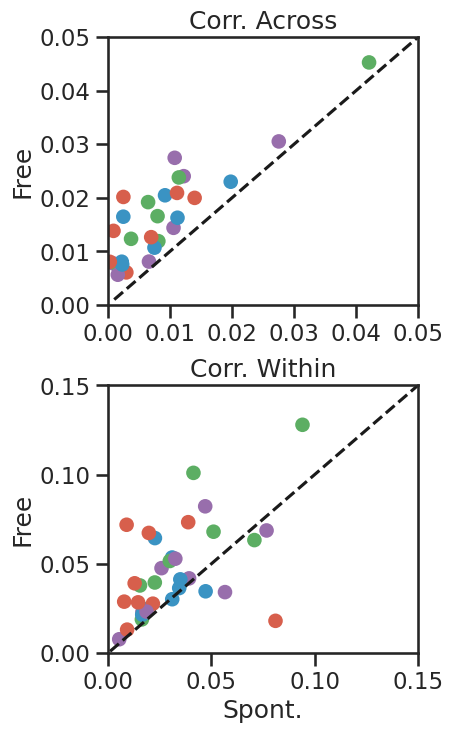

In [169]:
from pathlib import Path
with plt.style.context('seaborn-v0_8-bright'):
    sns.set_theme(context='talk', style='ticks')
    fig, ax = plt.subplots(2, 1, figsize=(4, 8), gridspec_kw={'hspace': 0.3})

    for session in sessions:

        ax[0].scatter(x=np.abs(corr_across[session]['intertrial']), y=np.abs(corr_across[session]['free']), c=[getattr(colors, f"{area}_light") for area in areas])
        ax[1].scatter(x=np.abs(corr_within[session]['intertrial']), y=np.abs(corr_within[session]['free']), c=[getattr(colors, f"{area}_light") for area in areas])

    ax[0].plot(np.arange(0.001, 1, 0.001), np.arange(0.001, 1, 0.001), 'k--')

  
    ax[1].set_xlabel('Spont.')
    ax[0].set_ylabel('Free')
    ax[1].set_ylabel('Free')



    ax[0].set_xlim([0, 0.05])
    ax[0].set_ylim([0, 0.05])
    ax[0].set_title('Corr. Across')

    ax[1].plot(np.arange(0.001, 1, 0.001), np.arange(0.001, 1, 0.001), 'k--')
    ax[1].set_xlim([0, 0.15])
    ax[1].set_ylim([0, 0.15])
    ax[1].set_yticks(np.arange(0, 0.20, 0.05))
    ax[1].set_xticks(np.arange(0, 0.20, 0.05))


   
    ax[1].set_title('Corr. Within')


figpath = Path('/home/me24/tmp_results')

fig.savefig(figpath / 'corre_across_within.pdf', bbox_inches='tight')

plt.show()

# Advanced analaysis
Multiple sessions

In [12]:
# Concatenate DF

areas=["MOp", "SSp", "CP", "VAL"]

sessions = [
    # 'M046_2024_12_18_16_00' 
    # 'M046_2024_12_19_13_30',
    # 'M061_2025_03_04_14_00',
    # 'M061_2025_03_05_14_00',
    # 'M061_2025_03_06_14_00',
    # 'M062_2025_03_19_14_00',
    # 'M062_2025_03_20_14_00',
    # 'M062_2025_03_21_14_00',
    # 'M063_2025_03_12_14_00',
    'M063_2025_03_13_14_00',
    # 'M063_2025_03_14_15_30'
]

data_dir = "/data/bnd-data/raw/"

df_ = []
for session in sessions:
    df = pyal.load_pyaldata(data_dir + session[:4] + '/' + session)
    df = preprocess(df, only_trials=False)

    df_.append(df)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
field idx_motion could not be converted to int.
array field all_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
field values_Sol_direction could not be converted to int.
field idx_Sol_direction could not be converted to int.
field values_Sol_duration could not be converted to int.
field idx_Sol_duration could not be converted to int.
field idx_sol_on could not be converted to int.
arr

/home/me24/.cache/pypoetry/virtualenvs/earthquake-analysis-Z8riI-lB-py3.12/src/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_X might be a time-varying field. It matches the length of all_spikes on 99.86149584487535% of trials
  warnings.warn(
/home/me24/.cache/pypoetry/virtualenvs/earthquake-analysis-Z8riI-lB-py3.12/src/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_X might be a time-varying field. It matches the length of all_spikes on 99.86149584487535% of trials
  warnings.warn(
/home/me24/.cache/pypoetry/virtualenvs/earthquake-analysis-Z8riI-lB-py3.12/src/PyalData/pyaldata/utils.py:155: UserWarning: values_MotSen1_Y might be a time-varying field. It matches the length of all_spikes on 99.86149584487535% of trials
  warnings.warn(
/home/me24/.cache/pypoetry/virtualenvs/earthquake-analysis-Z8riI-lB-py3.12/src/PyalData/pyaldata/utils.py:155: UserWarning: idx_MotSen1_Y might be a time-varying field. It matches the length of all_spikes on 99.86149584487535% of tr

Combined every 3 bins
Resulting all_spikes ephys data shape is (NxT): (43, 16000)
Resulting VAL_spikes ephys data shape is (NxT): (188, 16000)
Resulting SSp_spikes ephys data shape is (NxT): (131, 16000)
Resulting MOp_spikes ephys data shape is (NxT): (197, 16000)
Resulting CP_spikes ephys data shape is (NxT): (408, 16000)


Session: M061_2025_03_05_14_00
MOp to MOp: 0.735
MOp to SSp: 0.364
MOp to CP: 0.110
MOp to VAL: 0.109
SSp to MOp: 0.336
SSp to SSp: 0.776
SSp to CP: 0.098
SSp to VAL: 0.114
CP to MOp: 0.307
CP to SSp: 0.311
CP to CP: 0.629
CP to VAL: 0.125
VAL to MOp: 0.247
VAL to SSp: 0.261
VAL to CP: 0.117
VAL to VAL: 0.633
Freed memory pool
MOp to MOp: 0.657
MOp to SSp: 0.137
MOp to CP: 0.142
MOp to VAL: 0.057
SSp to MOp: 0.122
SSp to SSp: 0.627
SSp to CP: 0.032
SSp to VAL: 0.004
CP to MOp: 0.168
CP to SSp: 0.051
CP to CP: 0.546
CP to VAL: 0.040
VAL to MOp: 0.074
VAL to SSp: 0.014
VAL to CP: 0.021
VAL to VAL: 0.574
Freed memory pool


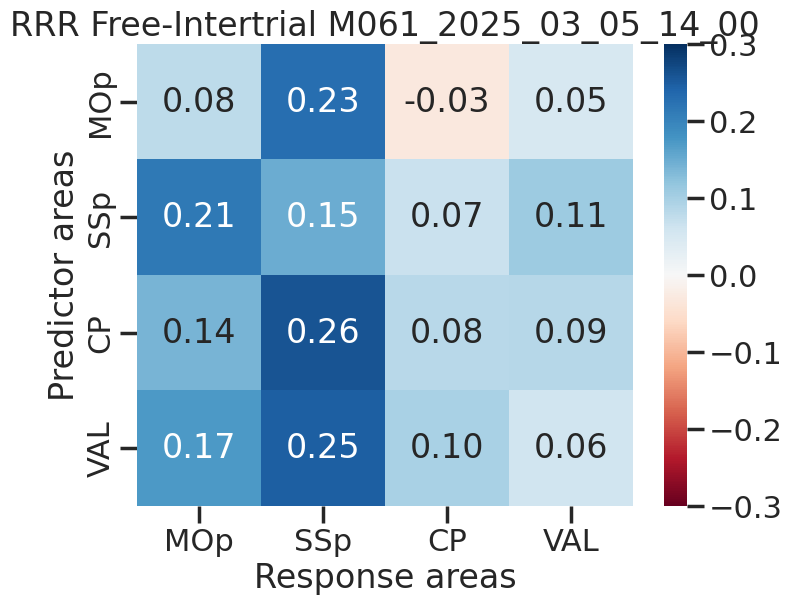

In [ ]:
n_comp=20
timepoints=None
for session, tmp_df in zip(sessions[:1], df_[:1]):
    print(f'Session: {session}')
    rrr_free_dict = rrr.compute_rrr_on_df(tmp_df, areas, condition='free', verbose=True, k_folds=10, timepoints=timepoints, free_period=0)
    # rrr_inter_dict = rrr.compute_rrr_on_df(tmp_df, areas, condition='intertrial', verbose=True, k_folds=10, timepoints=timepoints)

    # Assuming results_rrr_free1 and results_rrr_free2 have the same keys
    rrr_difference_dict = {}

    for area_x in rrr_inter_dict:
        rrr_difference_dict[area_x] = {}    
        for area_y in rrr_free_dict[area_x]:
            val1 = rrr_inter_dict[area_x][area_y]
            val2 = rrr_free_dict[area_x][area_y]
            rrr_difference_dict[area_x][area_y] = np.mean(val2 - val1)


    fig = viz_rrr.plot_rrr_heatmap_from_dict_per_area(
        rrr_difference_dict, 
        areas,  
        title=f'RRR Free-Intertrial {session}',
        vmin=-0.3,
        vmax=0.3
    )

### Double checking predictions from free1

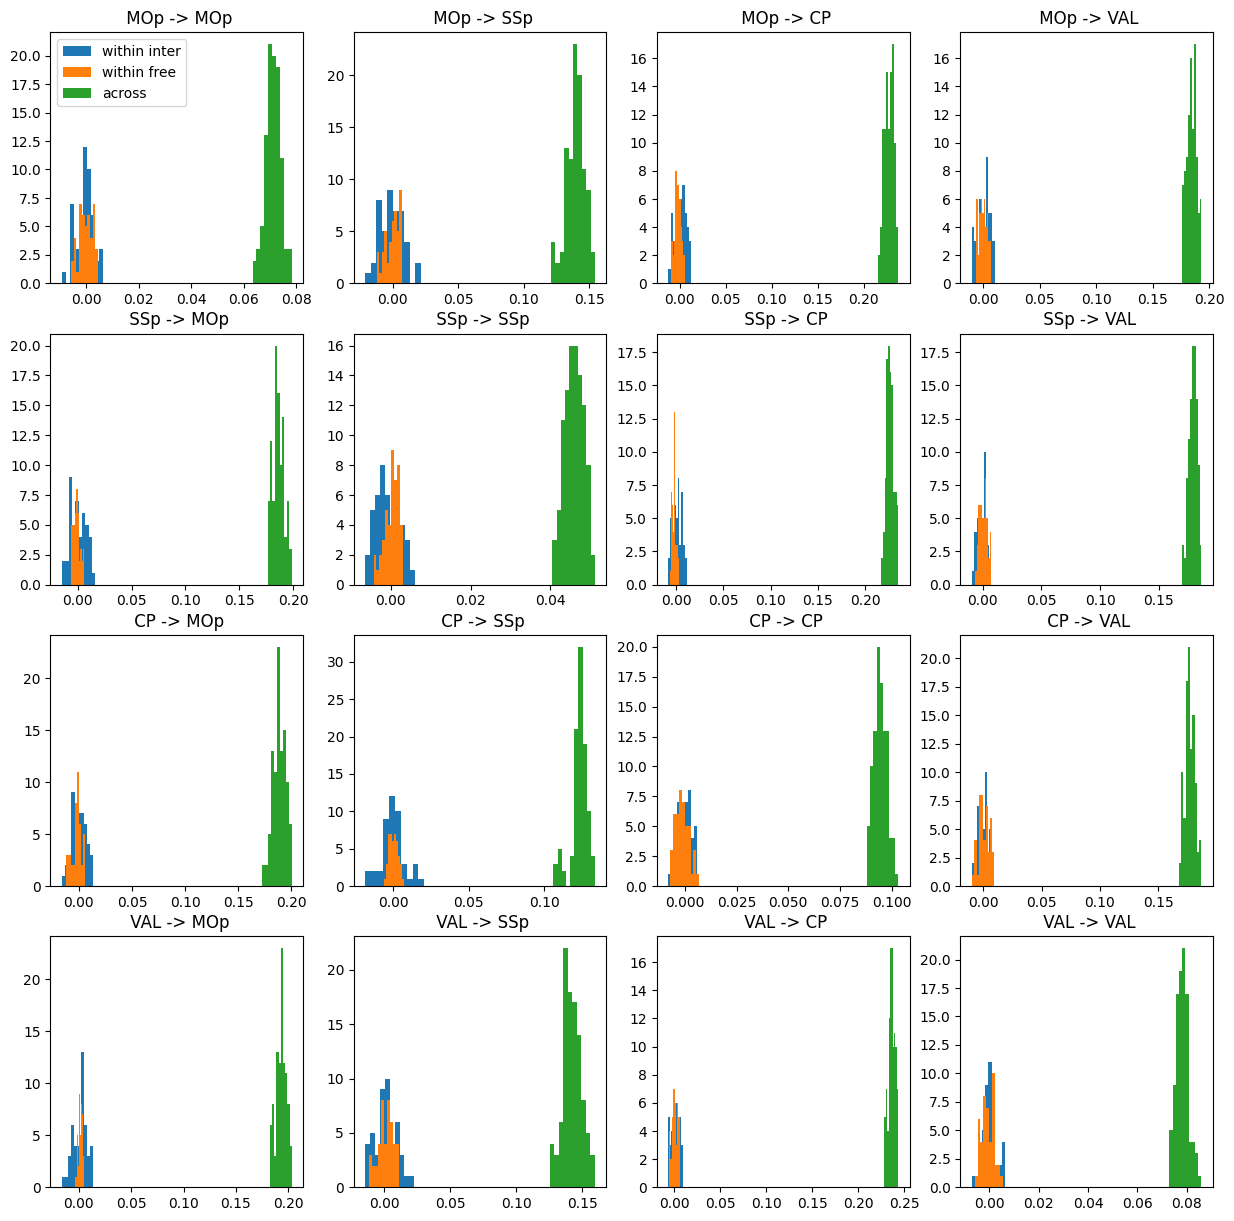

In [ ]:
from itertools import combinations
# Within-group differences

# 1 - free
# 2 - intertrial

def compute_within_differences(group):
    return np.array([x - y for x, y in combinations(group, 2)])


def compute_differences(area_1, area_2, dict_1, dict_2):
    group1 = dict_1[area_1][area_2]
    group2 = dict_2[area_1][area_2]

    across_diffs = np.array([[x - y for y in group2] for x in group1])
    within_diffs_group1 = compute_within_differences(group1)
    within_diffs_group2 = compute_within_differences(group2)

    return across_diffs, within_diffs_group1, within_diffs_group2


fig, axes = plt.subplots(4, 4, figsize=(15, 15))

for idx1, area_1 in enumerate(areas):  
    for idx2, area_2 in enumerate(areas):
        across_diffs, within_diffs_group1, within_diffs_group2 = compute_differences(area_1, area_2, 
                                                                                     rrr_free_dict, rrr_inter_dict)
        axes[idx1, idx2].hist(within_diffs_group2, label='within inter')
        axes[idx1, idx2].hist(within_diffs_group1, label='within free')
        axes[idx1, idx2].hist(across_diffs.flatten(), label='across')
        axes[idx1, idx2].set_title(f' {area_1} -> {area_2}')
axes[0, 0].legend()
plt.show()


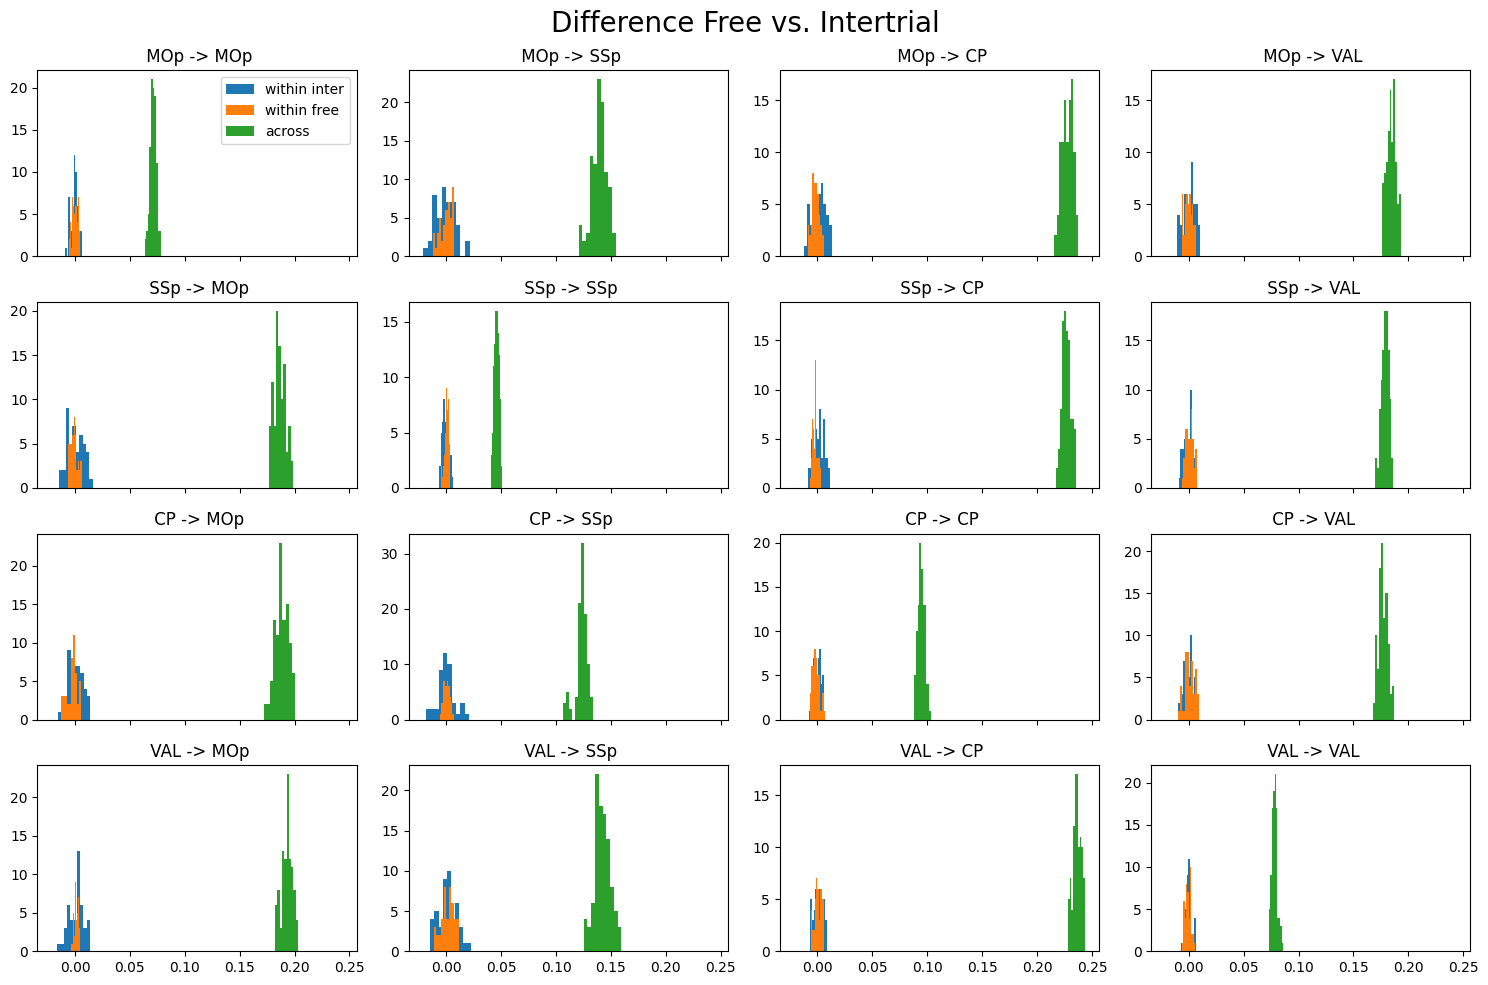

In [73]:

fig, axes = plt.subplots(4, 4, figsize=(15, 10), sharex='all')

for idx1, area_1 in enumerate(areas):  
    for idx2, area_2 in enumerate(areas):
        across_diffs, within_diffs_group1, within_diffs_group2 = compute_differences(area_1, area_2, 
                                                                                     rrr_free_dict, rrr_inter_dict)
        axes[idx1, idx2].hist(within_diffs_group2, label='within inter')
        axes[idx1, idx2].hist(within_diffs_group1, label='within free')
        axes[idx1, idx2].hist(across_diffs.flatten(), label='across')
        axes[idx1, idx2].set_title(f' {area_1} -> {area_2}')
axes[0, 0].legend()
plt.suptitle('Difference Free vs. Intertrial', fontsize=20)
plt.tight_layout()
plt.show()

Session: M063_2025_03_13_14_00


/home/me24/repos/earthquake-analysis/notebooks/pipelines/../../tools/decoding/rrr.py:29: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [720]
  df_rrr = pyal.restrict_to_interval(df_rrr, epoch_fun=Params.perturb_epoch_long)
/home/me24/repos/earthquake-analysis/notebooks/pipelines/../../tools/decoding/rrr.py:29: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [720]
  df_rrr = pyal.restrict_to_interval(df_rrr, epoch_fun=Params.perturb_epoch_long)
/home/me24/repos/earthquake-analysis/notebooks/pipelines/../../tools/decoding/rrr.py:29: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [720]
  df_rrr = pyal.restrict_to_interval(df_rrr, epoch_fun=Params.perturb_epoch_long)
/home/me24/repos/earthquake-analys

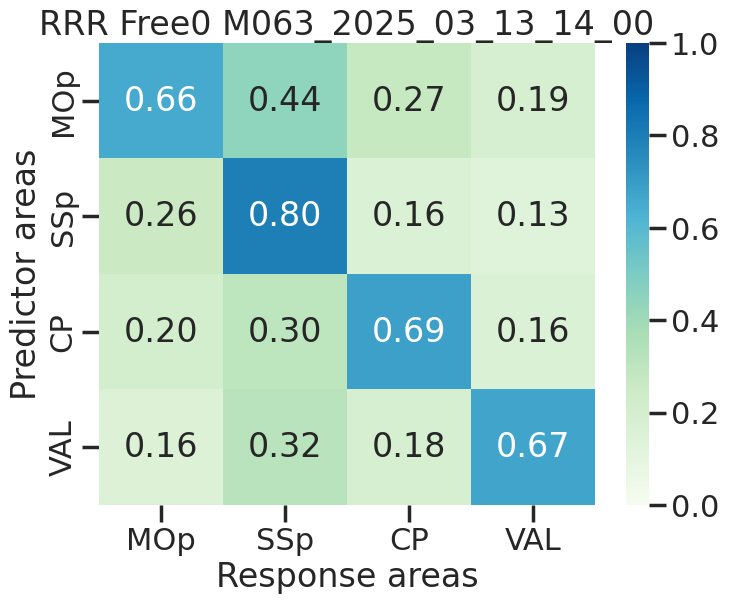

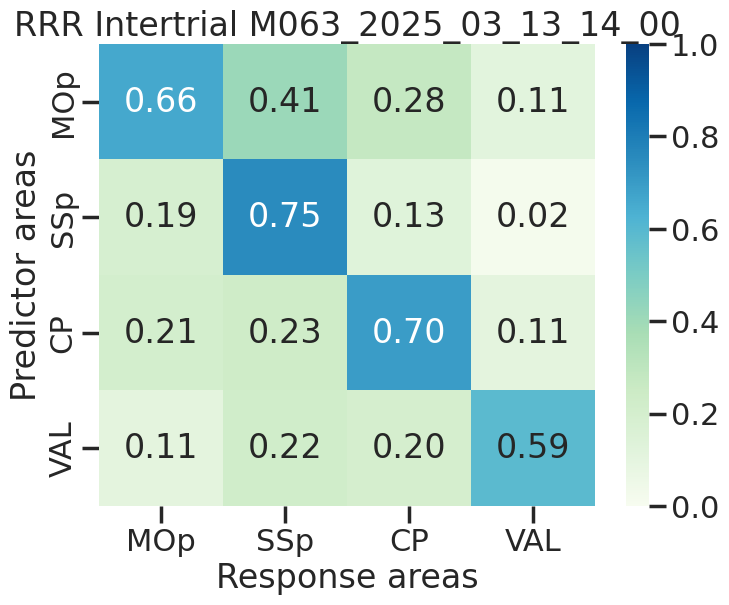

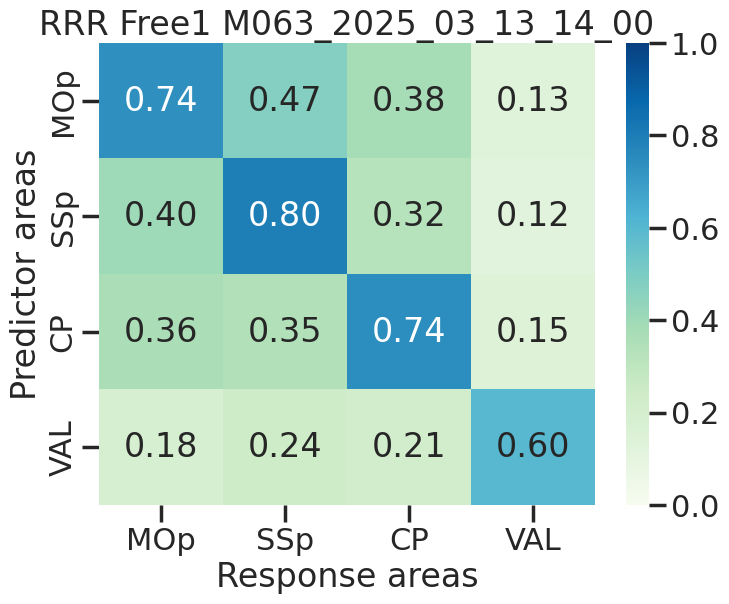

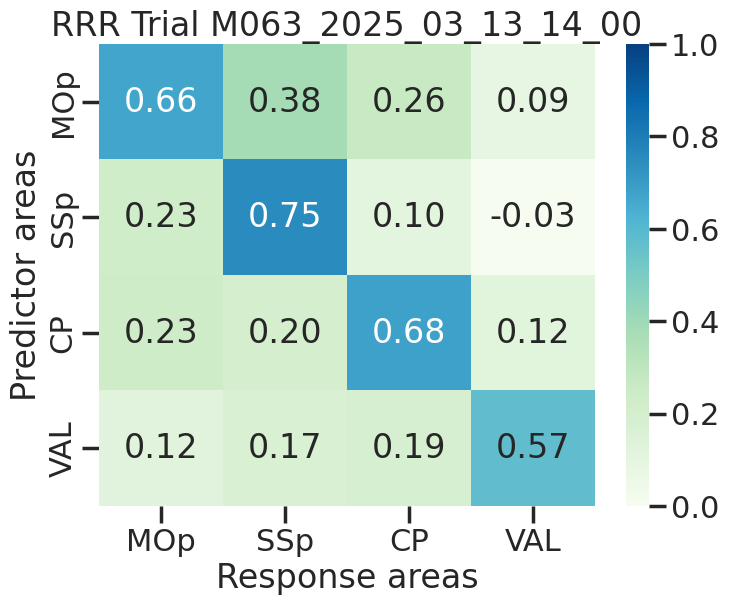

In [26]:
n_comp=20
timepoints=None
for session, tmp_df in zip(sessions[:1], df_[:1]):
    print(f'Session: {session}')
    rrr_free0_dict = rrr.compute_rrr_on_df(tmp_df, areas, condition='free', verbose=False, k_folds=10, timepoints=timepoints, free_period=0)
    rrr_inter_dict = rrr.compute_rrr_on_df(tmp_df, areas, condition='intertrial', verbose=False, k_folds=10, timepoints=timepoints)
    rrr_free1_dict = rrr.compute_rrr_on_df(tmp_df, areas, condition='free', verbose=False, k_folds=10, timepoints=timepoints, free_period=1)
    rrr_trial_dict = rrr.compute_rrr_on_df(tmp_df, areas, condition='trial', verbose=False, k_folds=10, timepoints=timepoints, free_period=1)


    fig = viz_rrr.plot_rrr_heatmap_from_dict_per_area(
        rrr_free0_dict, 
        areas,  
        title=f'RRR Free0 {session}',
        vmin=0,
        vmax=1,
        cmap='GnBu'
    )

    fig = viz_rrr.plot_rrr_heatmap_from_dict_per_area(
        rrr_inter_dict, 
        areas,  
        title=f'RRR Intertrial {session}',
        vmin=0,
        vmax=1,
        cmap='GnBu'

    )

    fig = viz_rrr.plot_rrr_heatmap_from_dict_per_area(
        rrr_free1_dict, 
        areas,  
        title=f'RRR Free1 {session}',
        vmin=0,
        vmax=1,
        cmap='GnBu'
    )

    fig = viz_rrr.plot_rrr_heatmap_from_dict_per_area(
        rrr_trial_dict, 
        areas,  
        title=f'RRR Trial {session}',
        vmin=0,
        vmax=1,
        cmap='GnBu'
    )

In [23]:
from tools.decoding.rrr import ReducedRankRegression, _get_data_for_rrr
from sklearn.model_selection import KFold


X = _get_data_for_rrr(df_[0], 'MOp', condition='free', free_period=0)
Y = _get_data_for_rrr(df_[0], 'CP', condition='free', free_period=0)

kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    model = ReducedRankRegression(r=10, lam=0.05, use_sklearn=False)
    model.fit(X=X_train, Y=Y_train)

    # Predict
    Y_pred_test = model.predict(X_test)
    multi_r2, col_r2 = decutils.multivariate_r2(Y_test, Y_pred_test)
    print(multi_r2)

0.4475582104620156
0.4448668965875401
0.4546950786349391
0.4472638829488014
0.45044650839646727
0.440623871119433
0.4558314746759199
0.4370312786777154
0.45063938201746523
0.4523337333006415


In [24]:
col_r2

array([0.70204636, 0.76235128, 0.55207374, 0.50381192, 0.28154434,
       0.35422519, 0.21272658, 0.1061766 , 0.11017527, 0.09303639,
       0.15187868, 0.11628932, 0.10514167, 0.12708448, 0.04256137,
       0.05359913, 0.05009647, 0.040066  , 0.00720639, 0.0170217 ])

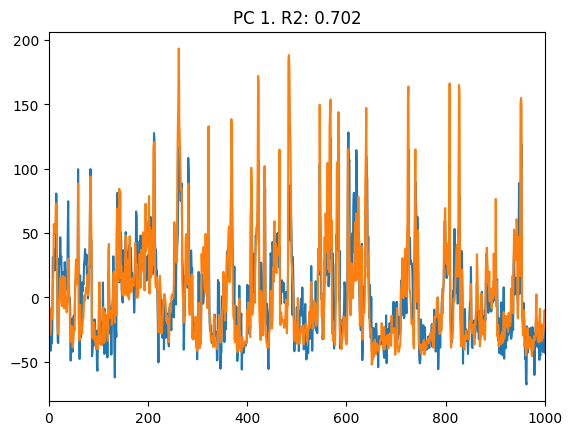

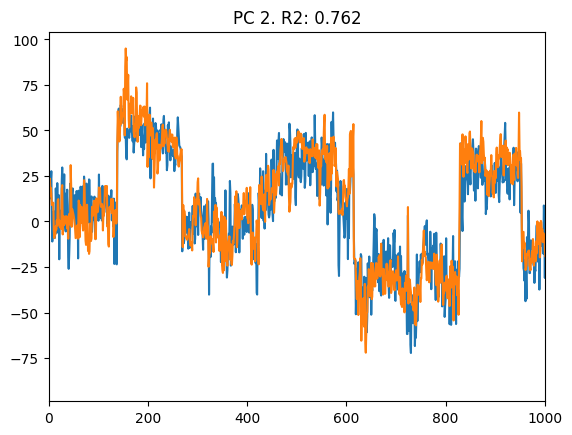

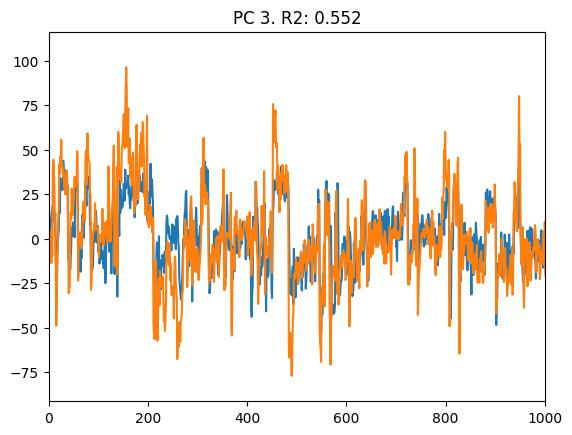

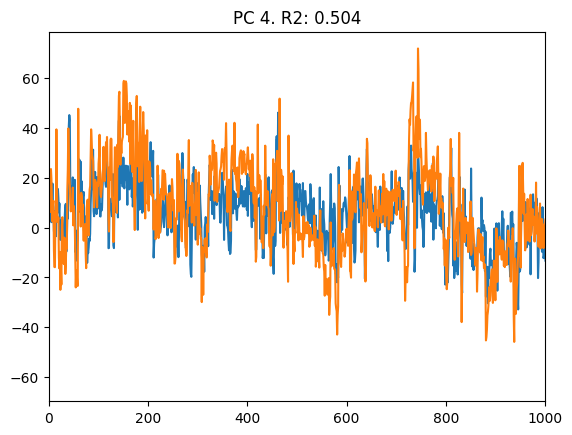

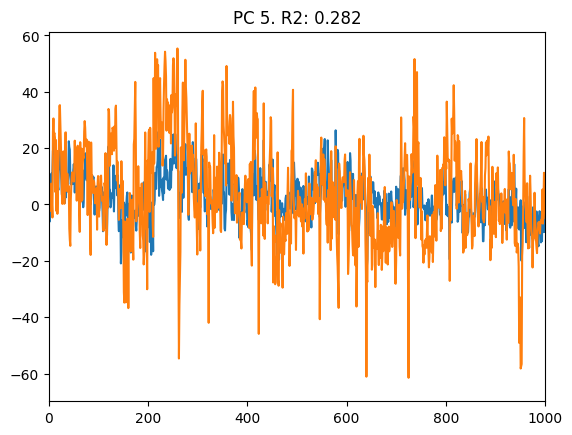

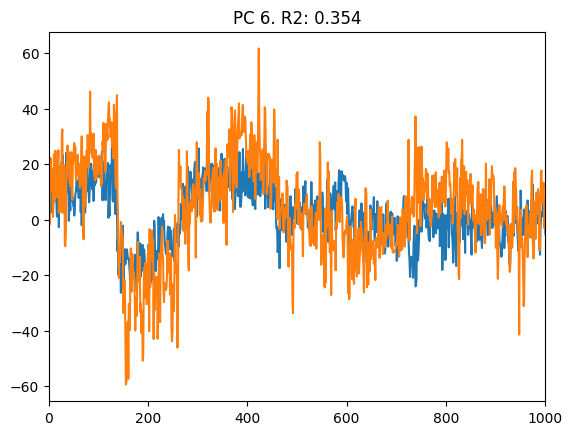

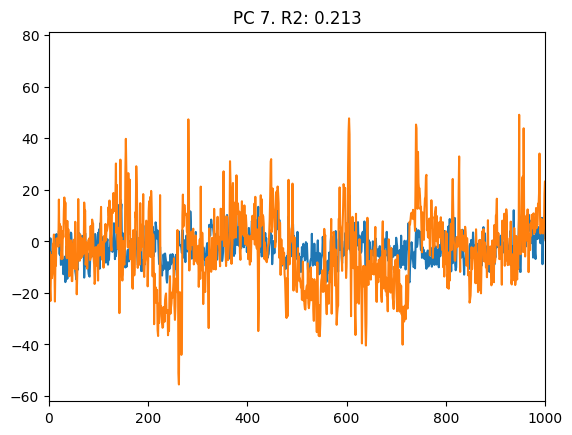

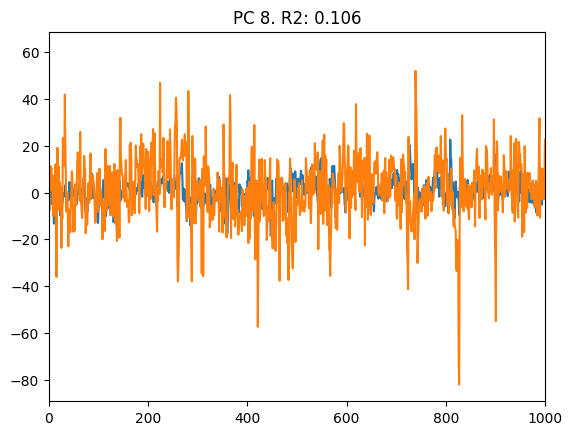

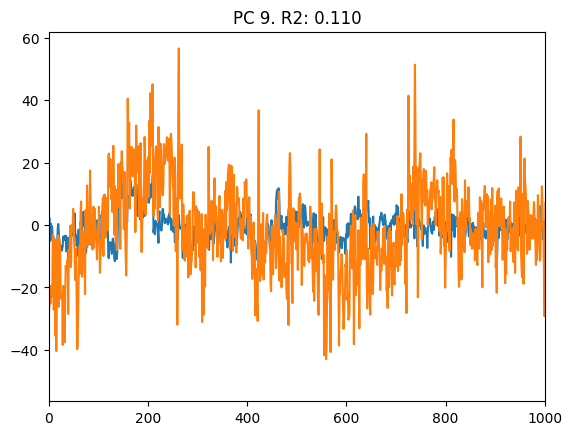

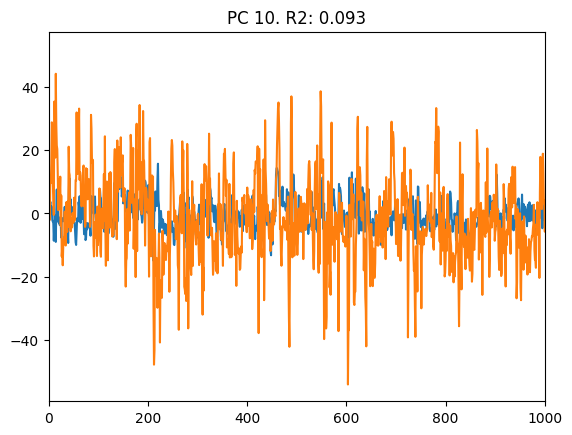

In [25]:
for pc, r2 in zip(range(10), col_r2[:10]):
    plt.figure()
    plt.plot(Y_pred_test[:, pc])
    plt.plot(Y_test[:, pc])
    plt.title(f'PC {pc+1}. R2: {r2:.3f}')
    plt.xlim([0, 1000])
    plt.show()

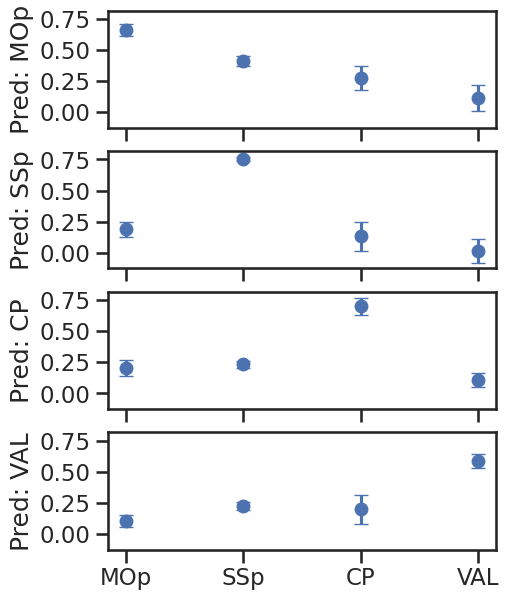

In [49]:
from tools.viz.rrr import plot_r2_with_errorbars


plot_r2_with_errorbars(rrr_inter_dict, areas)

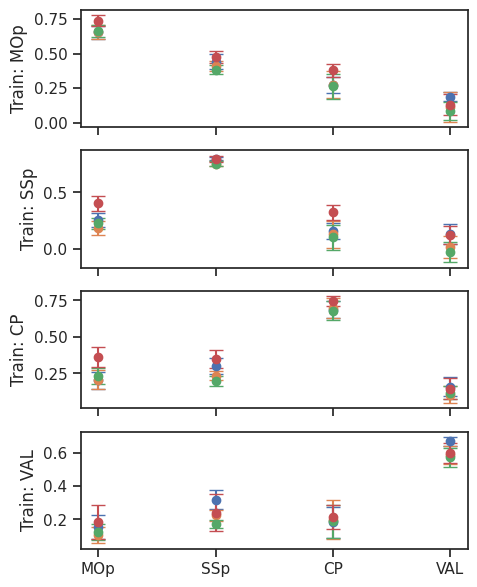

In [59]:
rrr_dict = {
    'free0': rrr_free0_dict,
    'intertrial': rrr_inter_dict,
    'trial': rrr_trial_dict,
    'free1': rrr_free1_dict
}
plot_r2_with_errorbars(rrr_dict, areas)